# Classification Automatique des Biens de Consommation par Réseaux de Neurones Convolutionnels

<a id ='sec:introduction'></a>
### Introduction : Exploitation des Réseaux Neuronaux Convolutifs (CNN) pour la Classification d'Images


Dans ce notebook, nous entamons un voyage de développement de modèle, d'expérimentation et de perfectionnement, chaque étape nous rapprochant d'un système automatisé capable de catégoriser des biens de consommation avec une précision remarquable.

Nous commençons par un modèle CNN fondamental pour la classification d'images, posant ainsi les bases pour des explorations ultérieures. Au fur et à mesure de notre progression, nous introduisons des améliorations, telles que des techniques d'augmentation de données qui rendent notre modèle robuste et adaptable à une large gamme de scénarios du monde réel.

De plus, nous explorons différentes approches de chargement de données, allant des méthodes basées sur les DataFrames aux stratégies basées sur les répertoires, mettant en évidence la polyvalence dans la gestion des données d'image. Enfin, nous intégrons l'augmentation de données directement dans l'architecture du CNN, présentant ainsi une approche globale de la classification d'images.

In [1]:
# pour editer le jeu de donne
import pandas as pd
import numpy as np
import datetime as dt
import time
from IPython.display import Image
# pour visualiser 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
from scipy import stats
import os
import imagesize

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [2]:
!python --version

print('\nfully imported')
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print('\npartially imported')
print("deep_translator -", importlib.metadata.version('deep_translator'))
print("importlib -", importlib.metadata.version('importlib.metadata'))
print("matplotlib -", importlib.metadata.version('matplotlib'))
print("numpy -", importlib.metadata.version('numpy'))

Python 3.8.3

fully imported
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
missingno - 0.4.2
cufflinks - 0.17.3

partially imported
deep_translator - 1.11.4
importlib - 6.6.0
matplotlib - 3.6.2
numpy - 1.23.5


### Table des Matières
- [Introduction : Exploitation des Réseaux Neuronaux Convolutifs (CNN) pour la Classification d'Images](#sec:introduction)
- [Section 1 : Modèle CNN de Base](#sec:modele-cnn-de-base)
- [Section 2 : Augmentation de Données avec Data Flow](#sec:augmentation-de-donnees-avec-data-flow)
- [Section 3 : Chargement de Données Basé sur les Répertoires](#sec:chargement-de-donnees-base-sur-les-repertoires)
- [Section 4 : Augmentation de Données au sein du Modèle](#sec:augmentation-de-donnees-au-sein-du-modele)
- [Perspectives : Approches de Fusion et Amélioration Continue](#sec:perspectives)
- [Conclusion : Réflexions et Avancées dans la Classification d'Images](#sec:conclusion)

In [6]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [7]:
# Fonction pour extraire les noms de catégories
def extraire_categories(ligne):
    categories = eval(ligne['product_category_tree'])  # Convertir la chaîne de catégories en liste
    return [categorie.strip() for categorie in categories[0].split('>>')]  # Diviser et nettoyer les catégories

# Appliquer la fonction au DataFrame
df['categories'] = df.apply(extraire_categories, axis=1)  # Créer une nouvelle colonne 'categories'

# Créer des colonnes distinctes pour chaque catégorie
max_categories = max(df['categories'].apply(len))  # Trouver le nombre maximal de catégories dans une ligne
for i in range(max_categories):
    df[f'Cat_{i+1}'] = df['categories'].apply(lambda x: x[i] if len(x) > i else None)  # Créer des colonnes pour chaque catégorie

# Supprimer la colonne originale 'categories'
df.drop('categories', axis=1, inplace=True)

<a id ='sec:modele-cnn-de-base'></a>
## Section 1 : Modèle CNN de Base

In [8]:
# Répertoire contenant les images
image_dir = 'Flipkart/Images/'

# Importation de la fonction 'join' depuis le module 'os.path'
from os.path import join

# Création d'une liste contenant les chemins complets vers les images
# La liste 'img_paths' va contenir les chemins vers les images correspondant à la colonne "image" du DataFrame df
img_paths = [join(image_dir, filename) for filename in df["image"].values]


In [9]:
# Création d'un tableau de données X contenant les chemins complets des images
X = np.array([image for image in img_paths])

# Extraction des étiquettes de catégories du DataFrame
y = df["Cat_1"]

# Importation de la fonction train_test_split depuis le module sklearn.model_selection
from sklearn.model_selection import train_test_split

# Division des données en ensembles d'entraînement et de test
# En utilisant train_test_split, les données sont divisées en x_train (données d'entraînement),
# x_test (données de test),
# y_train (étiquettes d'entraînement), y_test (étiquettes de test),
# name_images_train (noms des images dans l'ensemble d'entraînement) 
# et name_images_test (noms des images dans l'ensemble de test)
x_train, x_test, y_train, y_test, name_images_train, name_images_test = train_test_split(X,
                                                                                         y,
                                                                                         df["image"],
                                                                                         train_size=0.8,
                                                                                         stratify=y,
                                                                                         random_state=42)

In [12]:
import os
import cv2
from PIL import Image

# Chemins vers les répertoires d'images d'entraînement et de test
image_dir_train = '/Users/ismailcanoguz/Desktop/Project5/Flipkart/Image_train'
image_dir_test = '/Users/ismailcanoguz/Desktop/Project5/Flipkart/Image_test'

# Taille souhaitée pour redimensionner les images
image_resize = 224

# Boucle pour redimensionner et sauvegarder les images dans le jeu d'entraînement
for x_, y_, name_image in zip(x_train, y_train, name_images_train):
    new_dir = image_dir_train + "/" + y_
    if not os.path.exists(new_dir):
         os.makedirs(new_dir)
    image_resized = cv2.resize(cv2.imread(x_), (image_resize, image_resize)) # Redimensionnement de l'image
    image_recoded = Image.fromarray(image_resized) # Conversion d'un tableau en image
    image_recoded.save(os.path.join(new_dir, name_image)) # Sauvegarde de l'image redimensionnée

# Initialisation des listes pour les caractéristiques et les étiquettes du jeu de test
test_features, test_labels = [], []

# Boucle pour redimensionner et sauvegarder les images dans le jeu de test
for x_, y_, name_image in zip(x_test, y_test, name_images_test):
    new_dir = image_dir_test + "/" + y_
    if not os.path.exists(new_dir):
         os.makedirs(new_dir)
    image_resized = cv2.resize(cv2.imread(x_), (image_resize, image_resize)) # Redimensionnement de l'image
    test_features.append(image_resized) # Ajout des caractéristiques de l'image redimensionnée
    test_labels.append(y_) # Ajout de l'étiquette correspondante
    image_recoded = Image.fromarray(image_resized) # Conversion d'un tableau en image
    image_recoded.save(os.path.join(new_dir, name_image)) # Sauvegarde de l'image redimensionnée

In [13]:
# Création d'un dictionnaire pour encoder les étiquettes
encodage_labels = {label: idx for idx, label in enumerate(df['Cat_1'].unique())}

In [14]:
# Fonction pour générer un DataFrame à partir d'un répertoire donné
def generate_dataframe(main_directory):
    data = []  # Liste pour stocker les chemins d'images, les noms de répertoires et les étiquettes
    
    for root, _, files in os.walk(main_directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                directory_name = os.path.basename(root)  # Extrait le nom du répertoire
                label = encodage_labels.get(directory_name, -1)  # Obtient l'étiquette à partir du dictionnaire
                data.append({"image_path": file_path, "category_name": directory_name, "label": label})
    
    df = pd.DataFrame(data)
    return df

# Générer un DataFrame pour le jeu de test et le jeu d'entraînement
df_test = generate_dataframe(image_dir_test)
df_train = generate_dataframe(image_dir_train)

In [15]:
display(df_train)

,image_path,category_name,label
0,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
1,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
2,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
3,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
4,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
...,...,...,...
835,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
836,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
837,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
838,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1


In [16]:
display(df_test)

,image_path,category_name,label
0,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
1,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
2,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
3,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
4,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
...,...,...,...
205,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
206,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
207,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
208,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1


#### Approche d'Extraction de Caractéristiques et de Réduction de Dimension à l'aide du Modèle Pré-entraîné VGG

Dans cette étape, nous nous concentrons sur l'extraction de caractéristiques à partir d'images en utilisant un modèle VGG16 pré-entraîné. Le modèle VGG16 a été configuré pour enlever la couche de classification supérieure, ne conservant que les couches antérieures responsables de l'extraction de caractéristiques. En parcourant chaque image dans l'ensemble de données d'entraînement, nous effectuons les étapes suivantes :

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

Ce code charge le modèle VGG16 pré-entraîné et crée un nouveau modèle en utilisant toutes les couches jusqu'à l'avant-dernière couche. Cela signifie que la couche de sortie du modèle VGG16 est exclue, et vous obtenez un modèle qui produit les caractéristiques extraites par le réseau VGG16 pour chaque image. Le résumé du modèle est affiché, montrant les détails des couches et du nombre de paramètres de chaque couche.

### Étude de Classification d'Images en Utilisant le Transfert de Connaissances avec VGG16

Dans cette approche, nous exploitons directement l'apprentissage par transfert pour construire un modèle de classification d'images en utilisant une base pré-entraînée VGG16. Contrairement à notre approche précédente axée sur l'extraction de caractéristiques et la réduction de dimension pour la visualisation, cette méthode met l'accent sur la construction d'un modèle de classification robuste. Nous chargeons le modèle VGG16 pré-entraîné en tant qu'extracteur de caractéristiques et ajoutons des couches supplémentaires pour construire notre modèle de classification. Les couches pré-entraînées VGG16 sont figées tandis que les couches ajoutées sont formées pour l'adaptation à notre tâche. En utilisant cette approche, nous obtenons des performances de classification précises grâce à l'exploitation des connaissances préalables apprises par VGG16 sur des tâches similaires. La division des données en ensembles d'entraînement, de validation et de test garantit la robustesse et l'évaluation fidèle de notre modèle.

In [20]:
# Définition de la fonction de préparation des images
def image_prep_fct(data):
    prepared_images = []  # Liste pour stocker les images préparées
    
    # Parcours de chaque image dans le jeu de données
    for image_num in range(len(data['image_path'])):
        # Chargement de l'image et redimensionnement à la taille cible
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)  # Conversion de l'image en tableau numpy
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))  # Redimensionnement
        img = preprocess_input(img)  # Prétraitement de l'image
        prepared_images.append(img)  # Ajout de l'image préparée à la liste
        
    prepared_images_np = np.array(prepared_images)  # Conversion de la liste en tableau numpy
    return prepared_images_np

# Préparation des images pour le jeu d'entraînement
images_np_train = image_prep_fct(df_train)
print(images_np_train.shape)

# Préparation des images pour le jeu de test
images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)


(840, 224, 224, 3)
(210, 224, 224, 3)


In [21]:
from keras.utils import to_categorical

# Conversion des étiquettes en catégories
X = images_np_train
y = to_categorical(df_train['label'])

X_test = images_np_test
y_test = to_categorical(df_test['label'])

# Division du jeu d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Affichage de la forme (dimensions) du jeu d'entraînement
print(X_train.shape)

(630, 224, 224, 3)


Ce code définit une fonction create_model_fct qui crée un modèle de classification en utilisant l'architecture VGG16 pré-entraînée avec quelques modifications. Les couches du modèle pré-entraîné sont figées pour ne pas être ré-entraînées. Ensuite, de nouvelles couches sont ajoutées pour l'adaptation spécifique à la classification des images de votre problème. Le modèle est compilé avec une fonction de perte et un optimiseur spécifiques, et son résumé est affiché. La fonction renvoie le modèle ainsi créé.

In [22]:
def create_model_fct():
    # Charger un modèle pré-entraîné VGG16 sans la couche supérieure
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Rendre les couches du modèle pré-entraîné non entraînables (figées)
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle pré-entraîné
    x = model0.output
    
    # Ajouter des couches au modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer un nouveau modèle avec les nouvelles couches
    model = Model(inputs=model0.input, outputs=predictions)
    
    # Compiler le modèle avec une fonction de perte et un optimiseur
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Afficher un résumé du modèle
    print(model.summary())
    
    return model


In [23]:
model1 = create_model_fct()  # Création du modèle en utilisant la fonction précédente

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
# Chemin pour enregistrer les meilleurs poids du modèle
model1_save_path1 = "./model1_best_weights.h5"

# Callback pour sauvegarder les poids du meilleur modèle en fonction de la perte de validation
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Callback pour arrêter l'entraînement si la perte de validation ne diminue pas pendant un certain nombre d'épochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste de callbacks à utiliser pendant l'entraînement
callbacks_list = [checkpoint, es]

In [25]:
# Entraîner le modèle avec les données d'entraînement et de validation
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                      callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.9181 - accuracy: 0.4175
Epoch 1: val_loss improved from inf to 1.67983, saving model to ./model1_best_weights.h5


/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



10/10 [==============================] - 53s 5s/step - loss: 5.9181 - accuracy: 0.4175 - val_loss: 1.6798 - val_accuracy: 0.7571
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.9812 - accuracy: 0.6635
Epoch 2: val_loss improved from 1.67983 to 1.33121, saving model to ./model1_best_weights.h5
10/10 [==============================] - 57s 6s/step - loss: 1.9812 - accuracy: 0.6635 - val_loss: 1.3312 - val_accuracy: 0.7619
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3698 - accuracy: 0.7317
Epoch 3: val_loss improved from 1.33121 to 1.18066, saving model to ./model1_best_weights.h5
10/10 [==============================] - 55s 6s/step - loss: 1.3698 - accuracy: 0.7317 - val_loss: 1.1807 - val_accuracy: 0.8000
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.7857
Epoch 4: val_loss improved from 1.18066 to 1.17083, saving model to ./model1_best_weights.h5
10/10 [==============================] - 57s 6s/step

In [26]:
# Calculer et afficher le score de perte et de précision pour l'entraînement
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Précision d'entraînement : {:.4f}".format(accuracy))
print()

# Calculer et afficher le score de perte et de précision pour la validation
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Précision de validation :  {:.4f}".format(accuracy))


20/20 [==============================] - 49s 2s/step - loss: 0.0037 - accuracy: 1.0000
Précision d'entraînement : 1.0000

7/7 [==============================] - 19s 3s/step - loss: 1.1832 - accuracy: 0.8476
Précision de validation :  0.8476


In [27]:
# Charger les poids du modèle sauvegardé après l'entraînement
model1.load_weights(model1_save_path1)

# Évaluer la précision du modèle sur les données de validation
loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Précision de validation :  {:.4f}".format(accuracy))

# Évaluer la précision du modèle sur les données de test
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Précision de test       :  {:.4f}".format(accuracy))


Précision de validation :  0.8238
Précision de test       :  0.8286


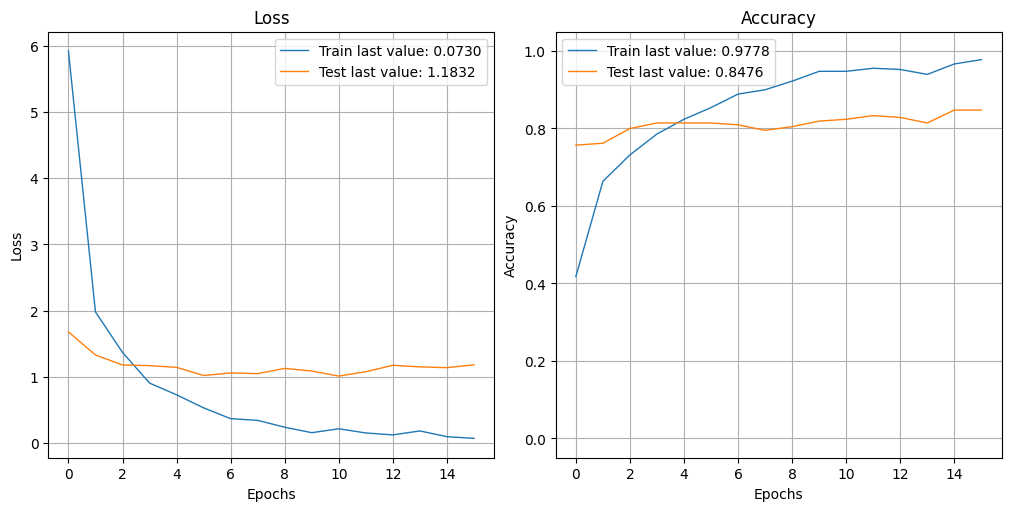

In [29]:
# Importer les fonctions nécessaires
from plot_keras_history import show_history, plot_history

# Afficher le graphique de l'historique d'entraînement
show_history(history1)

# Enregistrer le graphique de l'historique d'entraînement sous forme d'image
plot_history(history1, path="standard.png")

# Fermer la fenêtre du graphique
plt.close()

In [187]:
# Récupérer les indices des classes réelles et prédites pour les données de validation
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

# Afficher les indices des classes réelles et prédites pour les données de validation
print("Classes réelles :")
print(y_val_num)
print()
print("Classes prédites :")
print(y_val_pred)

7/7 [==============================] - 13s 2s/step
Classes réelles :
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

Classes prédites :
[0 2 6 2 4 1 1 0 2 5 2 6 1 6 5 2 1 1 6 5 4 2 6 6 5 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 2 1 2 6 5 4 0 0 6 4 6 5 3 1 3 5 3 5 4 4 0 4 1 6 6 2 5 0 0 4 3 5 3 5 0
 5 6 2 4 5 1 4 0 5 4 3 5 2 2 3 3 3 5 4 3 3 4 6 0 2 0 3 6 5 1 6 3 6 1 3 4 3
 0 3 2 5 2 0 6 1 5 5 2 3 1 0 3 3 6 3 6 5 1 2 2 6 1 0 5 4 4 3 3 5 1 0 4 5 1
 5 4 3 6 0 0 4 0 2 4 1 2 4 1 5 2 4 1 5 2 4 1 0 2 1 6 0 2 4 3 0 0 6 2 0 4 6
 1 0 2 3 1 3 1 1 1 5 0 5 0 2 3 1 6 0 2 4 3 6 3 6 5]


In [188]:
from sklearn import cluster, metrics

# Calculer la matrice de confusion entre les classes réelles et prédites
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
print(conf_mat)

Matrice de confusion :
[[23  6  0  1  0  0  0]
 [ 5 20  0  3  2  0  0]
 [ 0  0 28  1  1  0  0]
 [ 0  1  1 24  1  2  1]
 [ 1  0  0  0 24  3  2]
 [ 0  1  1  1  0 27  0]
 [ 0  1  1  1  0  0 27]]


In [189]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [190]:
# Transformer les prédictions en utilisant la correspondance des clusters
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Calculer la nouvelle matrice de confusion après transformation
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print("Nouvelle matrice de confusion après transformation :")
print(conf_mat)
print()

# Afficher le rapport de classification pour les classes réelles et prédites transformées
print("Rapport de classification après transformation :")
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
Nouvelle matrice de confusion après transformation :
[[23  6  0  1  0  0  0]
 [ 5 20  0  3  2  0  0]
 [ 0  0 28  1  1  0  0]
 [ 0  1  1 24  1  2  1]
 [ 1  0  0  0 24  3  2]
 [ 0  1  1  1  0 27  0]
 [ 0  1  1  1  0  0 27]]

Rapport de classification après transformation :
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.69      0.67      0.68        30
           2       0.90      0.93      0.92        30
           3       0.77      0.80      0.79        30
           4       0.86      0.80      0.83        30
           5       0.84      0.90      0.87        30
           6       0.90      0.90      0.90        30

    accuracy                           0.82       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.82      0.82      0.82       210



<AxesSubplot: >

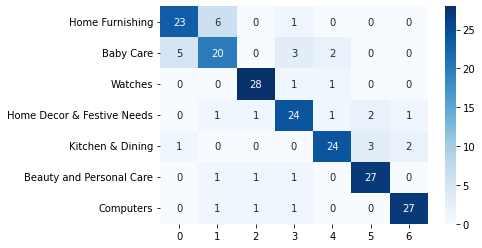

In [198]:
# Créer une DataFrame pour la matrice de confusion
df_cm = pd.DataFrame(conf_mat, index=[label for label in list(encodage_labels.keys())],
                     columns=[i for i in "0123456"])

# Créer une heatmap pour la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')

In [192]:
def compute_confusion_matrix(true_labels, predicted_labels):
    """
    Calcule et affiche la matrice de confusion et le rapport de classification.

    Paramètres :
    true_labels (array-like) : Labels réels ou vérité terrain.
    predicted_labels (array-like) : Labels prédits.

    Renvoie :
    None
    """
    # Obtenir les indices des classes réelles et prédites
    true_labels_num = np.argmax(true_labels, axis=1)
    predicted_labels_num = np.argmax(predicted_labels, axis=1)
    
    # Calculer la matrice de confusion initiale
    conf_mat = metrics.confusion_matrix(true_labels_num, predicted_labels_num)
    
    # Trouver la correspondance des classes prédites en utilisant argmax
    corresp = np.argmax(conf_mat, axis=0)

    # Transformer y_pred en utilisant la correspondance
    y_pred_transformed = [corresp[pred] for pred in predicted_labels_num]

    # Calculer la nouvelle matrice de confusion avec les prédictions transformées
    new_conf_mat = metrics.confusion_matrix(true_labels_num, y_pred_transformed)
    class_report = metrics.classification_report(true_labels_num, y_pred_transformed)

    # Afficher la correspondance des classes prédites
    print("Correspondance des Classes Prédites :", corresp)
    
    # Afficher la nouvelle matrice de confusion
    print("Matrice de Confusion")
    print(new_conf_mat)
    print()
    
    # Afficher le rapport de classification pour les nouvelles prédictions
    print("Rapport de Classification")
    print(class_report)
    
    # Update encodage_labels based on corresp
    new_encodage_labels = {k: v for v, k in sorted(zip(corresp, encodage_labels.keys()))}

    # Display the updated dictionary
    print("Updated encodage_labels:")
    print(new_encodage_labels)

In [193]:
compute_confusion_matrix(y_val, model1.predict(X_val))

7/7 [==============================] - 13s 2s/step
Correspondance des Classes Prédites : [0 1 2 3 4 5 6]
Matrice de Confusion
[[23  6  0  1  0  0  0]
 [ 5 20  0  3  2  0  0]
 [ 0  0 28  1  1  0  0]
 [ 0  1  1 24  1  2  1]
 [ 1  0  0  0 24  3  2]
 [ 0  1  1  1  0 27  0]
 [ 0  1  1  1  0  0 27]]

Rapport de Classification
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.69      0.67      0.68        30
           2       0.90      0.93      0.92        30
           3       0.77      0.80      0.79        30
           4       0.86      0.80      0.83        30
           5       0.84      0.90      0.87        30
           6       0.90      0.90      0.90        30

    accuracy                           0.82       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.82      0.82      0.82       210

Updated encodage_labels:
{'Home Furnishing': 0, 'Baby Care': 1, 'Watches': 2, 'Ho

In [194]:
compute_confusion_matrix(y_test, model1.predict(X_test))

7/7 [==============================] - 13s 2s/step
Correspondance des Classes Prédites : [0 1 2 3 4 5 6]
Matrice de Confusion
[[25  3  0  1  0  0  1]
 [ 7 21  0  1  0  0  1]
 [ 0  0 29  1  0  0  0]
 [ 1  1  0 24  2  0  2]
 [ 0  0  0  0 30  0  0]
 [ 1  1  0  3  1 21  3]
 [ 1  0  1  3  1  0 24]]

Rapport de Classification
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        30
           1       0.81      0.70      0.75        30
           2       0.97      0.97      0.97        30
           3       0.73      0.80      0.76        30
           4       0.88      1.00      0.94        30
           5       1.00      0.70      0.82        30
           6       0.77      0.80      0.79        30

    accuracy                           0.83       210
   macro avg       0.84      0.83      0.83       210
weighted avg       0.84      0.83      0.83       210

Updated encodage_labels:
{'Home Furnishing': 0, 'Baby Care': 1, 'Watches': 2, 'Ho

In [195]:
def print_performance_metrics(true_labels, predicted_labels):
    true_labels_num = np.argmax(true_labels, axis=1)
    predicted_labels_num = np.argmax(predicted_labels, axis=1)

    ARI = np.round(metrics.adjusted_rand_score(true_labels_num, predicted_labels_num), 2)
    homogeneity = np.round(metrics.homogeneity_score(true_labels_num, predicted_labels_num), 2)
    completeness = np.round(metrics.completeness_score(true_labels_num, predicted_labels_num), 2)
    v_measure = np.round(metrics.v_measure_score(true_labels_num, predicted_labels_num), 2)

    print(f"ARI Score:       {ARI}\n"
          f"Homogénéité:     {homogeneity}\n"
          f"Complétude:      {completeness}\n"
          f"V-Measure:       {v_measure}\n")

In [196]:
print_performance_metrics(y_test, model1.predict(X_test))

7/7 [==============================] - 13s 2s/step
ARI Score:       0.65
Homogénéité:     0.69
Complétude:      0.69
V-Measure:       0.69



In [110]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)

7/7 [==============================] - 14s 2s/step
[73]


In [124]:
def get_label_from_number(number, encodage_labels):
    # Use a try-except block to handle cases where the number is not found in the dictionary
    try:
        label = next(key for key, value in encodage_labels.items() if value == number)
        return label
    except StopIteration:
        return None  # Return None if the number is not found in the dictionary

Pour chaque cas où la prédiction du modèle s'est avérée incorrecte, ce code prend l'image du produit en question, l'affiche, puis la compare à la véritable catégorie du produit (que nous avons extraite de nos données de test) ainsi qu'à la catégorie prédite par le modèle CNN.

L'ensemble du processus nous donne une visualisation des produits pour lesquels notre modèle a eu des difficultés. Cela nous permet d'examiner visuellement ces cas d'erreurs et de mieux comprendre les situations où le modèle peut ne pas fonctionner aussi bien que prévu.

[151, 152, 156, 161, 166, 168, 171, 174, 176]


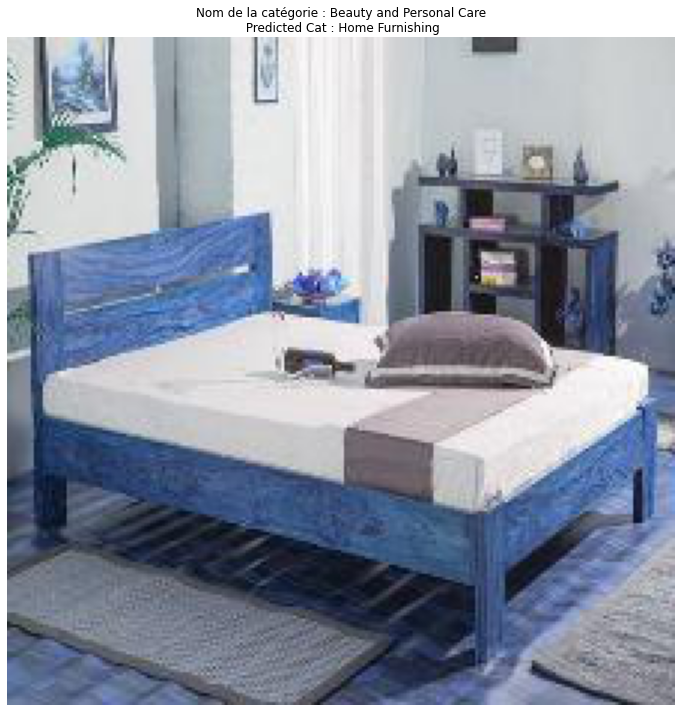

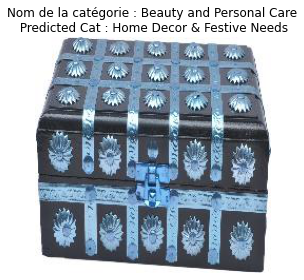

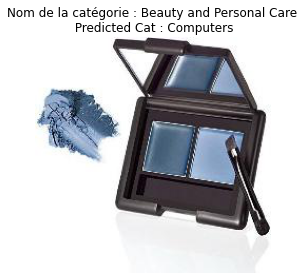

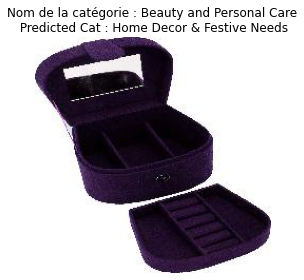

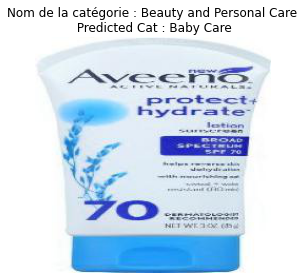

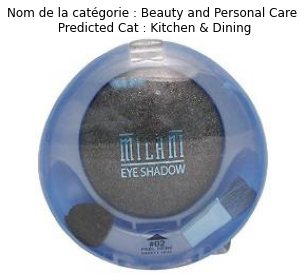

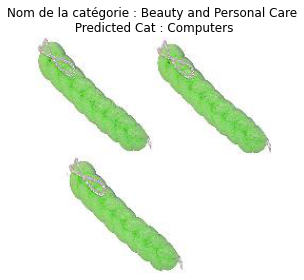

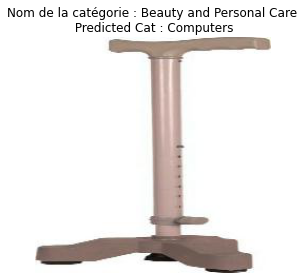

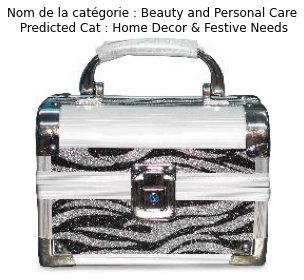

In [176]:
from matplotlib.image import imread

ids_a_afficher = [i for i in range(len(y_test_num))\
                if ((y_test_num[i]==5) and (y_test_pred[i]!=5))]
print(ids_a_afficher)

plt.figure(figsize=(10, 10))  # Augmentez la taille de la figure

for i, row_id in enumerate(ids_a_afficher):
    filename = df_test['image_path'][row_id]  # Obtenez le nom de fichier de l'image depuis la colonne 'image'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
    
    # Augmentez la taille et la police du titre
    cat_1 = df_test['category_name'][row_id]
    predicted_cat = y_test_pred[row_id]

    # Get the label for the predicted category
    predicted_label = get_label_from_number(predicted_cat, encodage_labels)#     description = df['description'][row_id]
    plt.title(f'Nom de la catégorie : {cat_1}\n Predicted Cat : {predicted_label}',)  # Ajustez la taille de la police selon vos préférences

    plt.tight_layout()
    plt.show()

<a id ='sec:augmentation-de-donnees-avec-data-flow'></a>
## Section 2 : Augmentation de Données avec Data Flow

### Amélioration de la Performance par l'Augmentation de Données et les Flux de Données dans la Classification d'Images

Cette approche diffère de la précédente en intégrant l'augmentation de données pendant le processus d'entraînement, permettant ainsi au modèle d'apprendre à partir de variations augmentées des images originales. De plus, au lieu de prédire directement sur des images individuelles et d'extraire manuellement des caractéristiques, cette approche exploite l'ImageDataGenerator pour créer des flux de données, gérant ainsi le prétraitement et l'augmentation de manière efficace.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# Pour mélanger les images dans le jeu d'entraînement
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [44]:
df_train

,image_path,category_name,label
0,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Beauty and Personal Care,5
1,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Baby Care,1
2,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
3,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Home Decor & Festive Needs,3
4,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
...,...,...,...
835,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
836,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Computers,6
837,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Watches,2
838,/Users/ismailcanoguz/Desktop/Project5/Flipkart...,Kitchen & Dining,4


In [45]:
# Taille des lots (batch size)
batch_size = 32

# Fonction pour générer les flux de données
def data_flow_fct(data, datagen, data_type=None):
    # Créer un flux de données à partir d'une DataFrame
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                            x_col='image_path', y_col='category_name',
                                            target_size=(256, 256),
                                            class_mode='categorical',
                                            batch_size=batch_size, shuffle=True, seed=42,
                                            subset=data_type)
    return data_flow

In [6]:
# Define a custom preprocessing function to adjust contrast
def adjust_contrast(image, contrast_factor=1.0):
    adjusted_image = tf.image.adjust_contrast(image, contrast_factor)
    return adjusted_image

# Parameters for data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=(0.8, 1.2),  # Add zooming in and out
    shear_range=0.2,  # Introduce shearing
    brightness_range=(0.5, 1.5),  # Vary brightness
    preprocessing_function=lambda x: adjust_contrast(x, contrast_factor=0.8),  # Adjust contrast
    validation_split=0.25
)

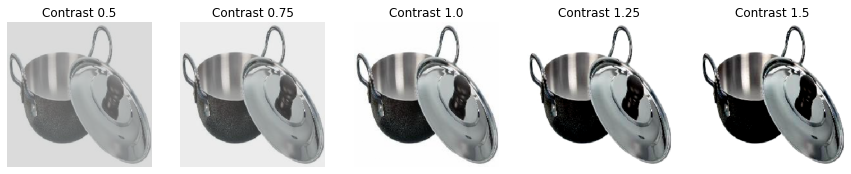

In [172]:
# Load the image you want to adjust contrast for
sample_image_path =  df_train['image_path'].iloc[10] # Replace with the path to your image
original_image = load_img(sample_image_path, target_size=(256, 256))
original_image = img_to_array(original_image) / 255.0  # Normalize pixel values to [0, 1]

# List of contrast factors to apply
contrast_factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # Adjust these as needed

# Create subplots for each contrast version
plt.figure(figsize=(15, 3))
for i, contrast_factor in enumerate(contrast_factors):
    # Apply the contrast adjustment
    adjusted_image = adjust_contrast(original_image, contrast_factor=contrast_factor)
    
    # Clip pixel values to the valid range [0, 1]
    adjusted_image = np.clip(adjusted_image, 0, 1)
    
    # Display the adjusted image
    plt.subplot(1, len(contrast_factors), i + 1)
    plt.title(f'Contrast {contrast_factor}')
    plt.imshow(adjusted_image)
    plt.axis('off')

plt.show()

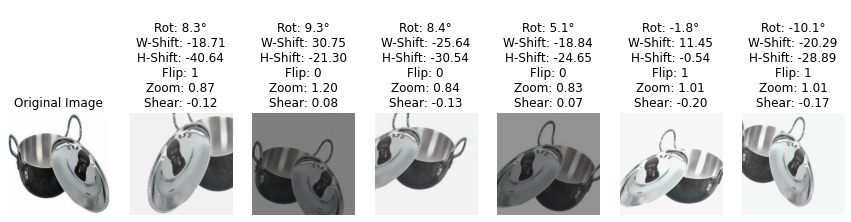

In [171]:
# Select one image from your dataset
sample_image = df_train['image_path'].iloc[10]

# Load and display the original image
original_image = plt.imread(sample_image)
plt.figure(figsize=(15, 6))
plt.subplot(1, 7, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

# Initialize the augmentation generator with a fixed seed for reproducibility
augmentation_generator = datagen_train.flow(np.array([original_image]), batch_size=1, seed=42)


# Apply and display multiple augmented versions of the selected image
for i in range(2, 8):
    augmented_image = augmentation_generator.next()[0]
    
    # Clip pixel values to the valid range [0, 255]
    augmented_image = np.clip(augmented_image, 0, 255).astype(np.uint8)
    
    # Get the applied transformation parameters
    rotation = datagen_train.get_random_transform(original_image.shape)['theta']
    width_shift = datagen_train.get_random_transform(original_image.shape)['tx']
    height_shift = datagen_train.get_random_transform(original_image.shape)['ty']
    horizontal_flip = datagen_train.get_random_transform(original_image.shape)['flip_horizontal']
    zoom = datagen_train.get_random_transform(original_image.shape)['zx']
    shear = datagen_train.get_random_transform(original_image.shape)['shear']
    
    plt.subplot(1, 7, i)
    plt.title(f'\nRot: {rotation:.1f}°\nW-Shift: {width_shift:.2f}\nH-Shift: {height_shift:.2f}\nFlip: {horizontal_flip}\nZoom: {zoom:.2f}\nShear: {shear:.2f}')
    plt.imshow(augmented_image)
    plt.axis('off')

plt.show()


In [7]:
# Paramètres de l'augmentation de données pour l'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,  # Fraction de données à utiliser pour la validation
    preprocessing_function=preprocess_input
)

In [48]:
# Générer les flux de données d'entraînement, de validation et de test
train_flow = data_flow_fct(df_train, datagen_train, data_type='training')
val_flow = data_flow_fct(df_train, datagen_train, data_type='validation')

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [49]:
# Paramètres de prétraitement des données de test
datagen_test = ImageDataGenerator(
    validation_split=0,  # Ne pas utiliser de validation pour les données de test
    preprocessing_function=preprocess_input
)

In [50]:
# Générer le flux de données de test
test_flow = data_flow_fct(df_test, datagen_test, data_type=None)


Found 210 validated image filenames belonging to 7 classes.


In [51]:
# Création du modèle
model2 = create_model_fct()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [52]:
# Chemin pour sauvegarder les meilleurs poids du modèle
model2_save_path = "./model2_best_weights.h5"

# Création d'un callback pour sauvegarder les meilleurs poids pendant l'entraînement
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Création d'un EarlyStopping callback pour arrêter l'entraînement si la perte de validation ne diminue plus
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste des callbacks à utiliser pendant l'entraînement
callbacks_list = [checkpoint, es]

In [53]:
# Entraînement du modèle avec les données générées à partir des flux de données
history2 = model2.fit(train_flow, validation_data=val_flow,
                      batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 4.1165 - accuracy: 0.4000
Epoch 1: val_loss improved from inf to 1.40047, saving model to ./model2_best_weights.h5
20/20 [==============================] - 83s 4s/step - loss: 4.1165 - accuracy: 0.4000 - val_loss: 1.4005 - val_accuracy: 0.6429
Epoch 2/50


/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



20/20 [==============================] - ETA: 0s - loss: 1.4868 - accuracy: 0.6635
Epoch 2: val_loss improved from 1.40047 to 0.94828, saving model to ./model2_best_weights.h5
20/20 [==============================] - 86s 4s/step - loss: 1.4868 - accuracy: 0.6635 - val_loss: 0.9483 - val_accuracy: 0.7190
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1438 - accuracy: 0.7238
Epoch 3: val_loss improved from 0.94828 to 0.76938, saving model to ./model2_best_weights.h5
20/20 [==============================] - 97s 5s/step - loss: 1.1438 - accuracy: 0.7238 - val_loss: 0.7694 - val_accuracy: 0.7619
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.8557 - accuracy: 0.7556
Epoch 4: val_loss did not improve from 0.76938
20/20 [==============================] - 88s 4s/step - loss: 0.8557 - accuracy: 0.7556 - val_loss: 0.7716 - val_accuracy: 0.7429
Epoch 5/50
20/20 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.7825
Epoch 5: val_lo

In [54]:
# Score du dernier epoch (évaluation sur les données d'entraînement et de validation)
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 71s 4s/step - loss: 0.1912 - accuracy: 0.9365
Training Accuracy   : 0.9365

7/7 [==============================] - 23s 3s/step - loss: 0.8903 - accuracy: 0.7571
Validation Accuracy :  0.7571


In [55]:
# Score de l'epoch optimal (chargement des meilleurs poids)
model2.load_weights(model2_save_path)

# Évaluation sur les données de validation
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Évaluation sur les données de test
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7429
Test Accuracy       :  0.7238


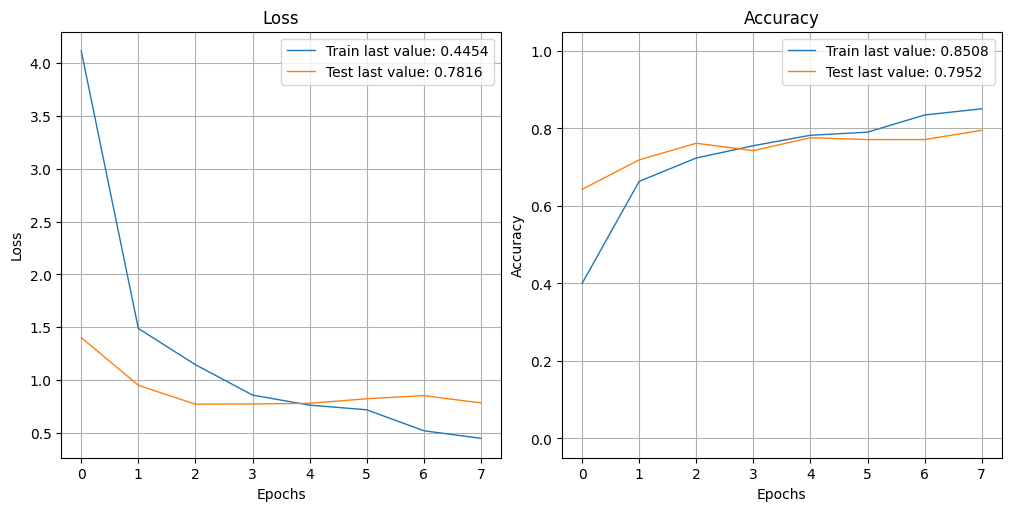

In [56]:
# Affichage des courbes d'apprentissage à l'aide de la bibliothèque plot_keras_history
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Affiche les courbes d'apprentissage dans la console
show_history(history2)

# Sauvegarde les courbes d'apprentissage dans un fichier image
plot_history(history2, path="standard.png")
plt.close()  # Ferme la figure matplotlib pour libérer la mémoire

In [104]:
compute_confusion_matrix(y_test, model2.predict(X_test))

7/7 [==============================] - 13s 2s/step
Correspondance des Classes Prédites : [1 5 6 3 0 4 2]
Matrice de Confusion
[[21  8  0  0  0  1  0]
 [ 5 19  0  0  3  2  1]
 [ 0  0 25  2  0  1  2]
 [ 1  1  0 22  3  1  2]
 [ 1  0  1  1 27  0  0]
 [ 1  0  2  1  1 22  3]
 [ 1  0  0  4  6  2 17]]

Rapport de Classification
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        30
           1       0.68      0.63      0.66        30
           2       0.89      0.83      0.86        30
           3       0.73      0.73      0.73        30
           4       0.68      0.90      0.77        30
           5       0.76      0.73      0.75        30
           6       0.68      0.57      0.62        30

    accuracy                           0.73       210
   macro avg       0.73      0.73      0.73       210
weighted avg       0.73      0.73      0.73       210

Updated encodage_labels:
{'Kitchen & Dining': 0, 'Home Furnishing': 1, 'Computers

<a id ='sec:chargement-de-donnees-base-sur-les-repertoires'></a>
## Section 3 : Chargement de Données Basé sur les Répertoires

#### Approche d'Entraînement avec Création Directe de Jeux de Données depuis des Répertoires d'Images

Cette approche présente une évolution dans la manière dont les données sont gérées et préparées pour l'entraînement du modèle. Elle repose sur la création directe de jeux de données à partir de répertoires d'images à l'aide de la fonction image_dataset_from_directory de TensorFlow. Cette méthode simplifie le chargement des données en garantissant l'étiquetage et le regroupement appropriés des images en lots. Contrairement aux approches précédentes impliquant le chargement manuel, le prétraitement et l'augmentation des images, cette méthode rationalise ces étapes. La création des jeux de données d'entraînement, de validation et de test est facilitée, permettant une intégration harmonieuse avec le modèle

In [57]:
batch_size = 32

# Fonction pour créer un jeu de données à partir d'un répertoire d'images
def dataset_fct(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical',
        class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
        validation_split=validation_split, subset=data_type
    )
    return dataset

In [58]:
# Création des jeux de données d'entraînement, de validation et de test
dataset_train = dataset_fct(image_dir_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(image_dir_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(image_dir_test, validation_split=0, data_type=None)


Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [59]:
# Création du modèle3 en utilisant la fonction create_model_fct
model3 = create_model_fct()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [60]:
# Création des callbacks pour le modèle
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [61]:
# Entraînement du modèle3 sur les jeux de données d'entraînement et de validation
history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 6.1180 - accuracy: 0.4698
Epoch 1: val_loss improved from inf to 1.41539, saving model to ./model3_best_weights.h5
20/20 [==============================] - 71s 4s/step - loss: 6.1180 - accuracy: 0.4698 - val_loss: 1.4154 - val_accuracy: 0.7667
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.1197 - accuracy: 0.7206
Epoch 2: val_loss improved from 1.41539 to 1.27710, saving model to ./model3_best_weights.h5
20/20 [==============================] - 72s 4s/step - loss: 2.1197 - accuracy: 0.7206 - val_loss: 1.2771 - val_accuracy: 0.8000
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.4506 - accuracy: 0.7508
Epoch 3: val_loss improved from 1.27710 to 1.24627, saving model to ./model3_best_weights.h5
20/20 [==============================] - 73s 4s/step - loss: 1.4506 - accuracy: 0.7508 - val_loss: 1.2463 - val_accuracy: 0.7952
Epoch 4/50
20/20 [==============================] - ETA:

In [62]:
# Score du dernier epoch

# Évaluation de la précision du modèle sur les données d'entraînement
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

# Évaluation de la précision du modèle sur les données de validation
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))


20/20 [==============================] - 39s 2s/step - loss: 0.0054 - accuracy: 0.9984
Training Accuracy   : 0.9984

7/7 [==============================] - 13s 2s/step - loss: 1.0937 - accuracy: 0.8143
Validation Accuracy :  0.8143


In [63]:
# Score de l'epoch optimal

# Chargement des poids du modèle ayant la meilleure performance sur les données de validation
model3.load_weights(model3_save_path)

# Évaluation de la précision du modèle chargé sur les données de validation
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Évaluation de la précision du modèle chargé sur les données de test
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8286
Test Accuracy       :  0.7857


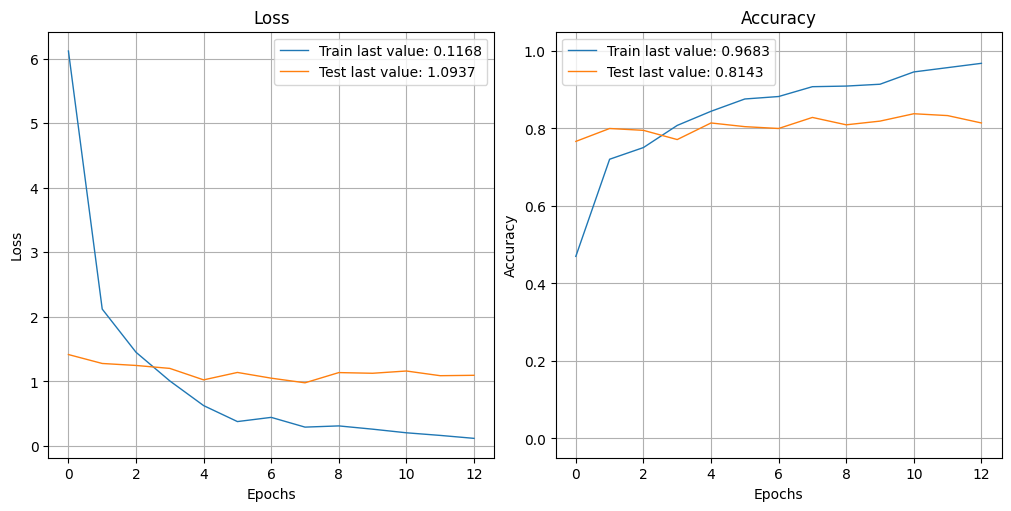

In [64]:
# Affichage des courbes d'entraînement et de validation en utilisant le module show_history
show_history(history3)

# Enregistrement des courbes d'entraînement et de validation dans un fichier "standard.png"
plot_history(history3, path="standard.png")

# Fermeture de la figure matplotlib
plt.close()

In [100]:
compute_confusion_matrix(y_test, model3.predict(X_test))

7/7 [==============================] - 12s 2s/step
Correspondance des Classes Prédites : [1 5 6 3 0 4 2]
Matrice de Confusion
[[27  3  0  0  0  0  0]
 [13 12  0  3  0  0  2]
 [ 0  0 30  0  0  0  0]
 [ 0  1  0 19  8  0  2]
 [ 0  2  0  0 27  0  1]
 [ 1  0  1  2  4 20  2]
 [ 2  0  2  2  0  0 24]]

Rapport de Classification
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        30
           1       0.67      0.40      0.50        30
           2       0.91      1.00      0.95        30
           3       0.73      0.63      0.68        30
           4       0.69      0.90      0.78        30
           5       1.00      0.67      0.80        30
           6       0.77      0.80      0.79        30

    accuracy                           0.76       210
   macro avg       0.77      0.76      0.75       210
weighted avg       0.77      0.76      0.75       210

Updated encodage_labels:
{'Home Furnishing': 1, 'Baby Care': 5, 'Watches': 6, 'Ho

<a id ='sec:augmentation-de-donnees-au-sein-du-modele'></a>
## Section 4 : Augmentation de Données au sein du Modèle

#### Amélioration de la Performance du Modèle par Augmentation de Données avec Préparation Automatique de Flux


Cette approche se distingue des précédentes par l'intégration de l'augmentation de données pendant le processus d'entraînement, ce qui permet au modèle d'apprendre à partir de variations augmentées des images originales. Contrairement aux méthodes précédentes où les images étaient préparées manuellement, cette approche exploite l'utilisation de l'ImageDataGenerator de TensorFlow pour créer des flux de données. Ces flux gèrent efficacement le prétraitement et l'augmentation des images, simplifiant ainsi le processus d'entraînement. En outre, un élément clé de cette approche est l'ajout d'une couche d'augmentation de données au début du modèle, ce qui permet d'appliquer des transformations aléatoires aux images pendant l'entraînement. Cette approche vise à améliorer la robustesse du modèle en l'entraînant sur une variété d'images augmentées, ce qui peut conduire à une meilleure performance sur des données inconnues.

In [65]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [66]:
# Création des jeux de données d'entraînement, de validation et de test à partir des répertoires d'images
dataset_train = dataset_fct(image_dir_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(image_dir_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(image_dir_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [67]:

# Création d'un modèle de classification avec augmentation de données
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération du modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Construction du modèle complet
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [68]:

# Création du modèle avec augmentation de données
model4 = create_model_fct2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [69]:
# Création des callbacks pour enregistrer les meilleurs poids du modèle
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [70]:

# Entraînement du modèle avec les jeux de données d'entraînement et de validation
history4 = model4.fit(dataset_train, validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8116 - accuracy: 0.2746
Epoch 1: val_loss improved from inf to 1.38371, saving model to ./model4_best_weights.h5
20/20 [==============================] - 57s 3s/step - loss: 1.8116 - accuracy: 0.2746 - val_loss: 1.3837 - val_accuracy: 0.6190
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3838 - accuracy: 0.4968
Epoch 2: val_loss improved from 1.38371 to 1.12610, saving model to ./model4_best_weights.h5
20/20 [==============================] - 56s 3s/step - loss: 1.3838 - accuracy: 0.4968 - val_loss: 1.1261 - val_accuracy: 0.6810
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.6063
Epoch 3: val_loss improved from 1.12610 to 0.88339, saving model to ./model4_best_weights.h5
20/20 [==============================] - 57s 3s/step - loss: 1.1543 - accuracy: 0.6063 - val_loss: 0.8834 - val_accuracy: 0.7857
Epoch 4/50
20/20 [==============================] - ETA:

In [71]:
# Score du dernier epoch pour le jeu d'entraînement et de validation
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 53s 3s/step - loss: 0.1981 - accuracy: 0.9429
Training Accuracy   : 0.9429

7/7 [==============================] - 18s 2s/step - loss: 0.5337 - accuracy: 0.8333
Validation Accuracy :  0.8333


In [72]:
# Chargement des poids du modèle avec la meilleure performance sur la validation
model4.load_weights(model4_save_path)

# Score du modèle sur le jeu de validation et de test avec les poids optimaux
loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8333
Test Accuracy       :  0.7952


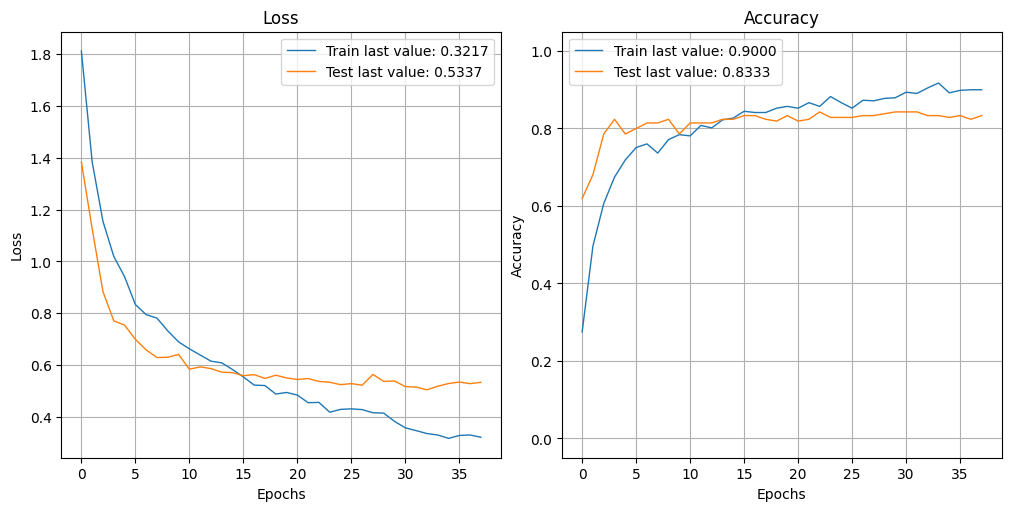

In [73]:

# Affichage de l'historique d'entraînement
show_history(history4)

# Sauvegarde du graphique de l'historique d'entraînement
plot_history(history4, path="standard.png")
plt.close()

In [101]:
compute_confusion_matrix(y_test, model4.predict(X_test))

7/7 [==============================] - 13s 2s/step
Correspondance des Classes Prédites : [1 5 6 3 0 4 2]
Matrice de Confusion
[[18 11  0  0  0  0  1]
 [ 5 20  0  1  1  0  3]
 [ 0  0 30  0  0  0  0]
 [ 0  1  0 21  5  0  3]
 [ 0  1  3  0 26  0  0]
 [ 2  1  3  0  0 21  3]
 [ 1  0  1  4  1  0 23]]

Rapport de Classification
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        30
           1       0.59      0.67      0.62        30
           2       0.81      1.00      0.90        30
           3       0.81      0.70      0.75        30
           4       0.79      0.87      0.83        30
           5       1.00      0.70      0.82        30
           6       0.70      0.77      0.73        30

    accuracy                           0.76       210
   macro avg       0.77      0.76      0.76       210
weighted avg       0.77      0.76      0.76       210

Updated encodage_labels:
{'Home Furnishing': 1, 'Baby Care': 5, 'Watches': 6, 'Ho

<a id ='sec:perspectives'></a>  
## Perspectives : Approches de Fusion et Amélioration Continue

En envisageant l'avenir de notre projet de classification automatique de produits, nous nous apprêtons à explorer une approche de fusion dynamique. Cette approche vise à augmenter la précision et la fiabilité de notre processus de catégorisation des produits en combinant les informations de notre classification de texte basée sur le TALN et de notre classification d'images basée sur les CNN.

__Approche de Fusion :__

Notre stratégie de fusion marque une avancée significative. Elle implique la fusion de données textuelles et d'images pour obtenir une catégorisation de produits plus nuancée.

Fusion Précoce : Cette approche intègre dès le départ les données textuelles et d'images, permettant au modèle de comprendre en profondeur les liens entre les descriptions textuelles et les images.

Fusion Tardive : Ici, nous continuons à former des modèles de texte et d'image séparément, mais nous fusionnons leurs sorties lors de la prise de décision. Cette flexibilité nous permet d'expérimenter différentes techniques de combinaison.

Réseaux Neuronaux Multi-Modaux : En alternative, nous pouvons créer un unique réseau neuronal qui traite à la fois les entrées textuelles et d'images, facilitant l'apprentissage conjoint et révélant des relations inter-modales.

L'approche de fusion promet d'améliorer la sophistication de notre classification automatique de produits. Il ne s'agit pas seulement de catégorisation, mais aussi de véritable compréhension. En combinant les données textuelles et d'images, nous visons une plus grande précision et résilience dans nos modèles, faisant progresser notre projet "Classifiez automatiquement des biens de consommation".

<a id ='sec:conclusion'></a>
## Conclusion : Réflexions et Avancées dans la Classification d'Images

Dans nos quatre modèles CNN, nous avons observé des variations de performances notables. Le modèle CNN de base a atteint une précision d'entraînement parfaite, mais a montré une légère baisse de la précision en validation et en test. L'incorporation de l'augmentation des données avec un flux de données a amélioré la précision d'entraînement, mais a légèrement réduit les précisions en validation et en test. Le chargement de données basé sur des répertoires a conduit à une précision d'entraînement exceptionnelle, mais à des précisions en validation et en test légèrement inférieures. Enfin, l'augmentation des données intégrée au modèle a maintenu une forte précision d'entraînement et des résultats stables en validation et en test. Ces constatations soulignent l'importance de l'augmentation des données et de la conception du modèle dans la classification d'images. Alors que nous explorons les approches de fusion, notre objectif est d'améliorer davantage la précision et la robustesse de la catégorisation des produits dans notre projet 'Classifiez automatiquement des biens de consommation'.